# Preprocessing

In [153]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
%autoreload 2

In [155]:
import torch

In [156]:
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
import pandas as pd
from src.vfm.model.reg.gradient_boost import GradientBoost
from src.vfm.model.nn.swt_tft import SWTTFTModel
from src.utils.descriptive_analysis import *
from src.vfm.model.physics.physics_informed import PhysicsInformedHybridModel, PhysicsModel
from src.utils import *
import matplotlib.pyplot as plt
import os

In [157]:
connection = Connection()
# Get client
client = connection.get_client()

In [158]:
df_all_wells = connection.get_data(client, wells=["W06"])

In [159]:
df_all_wells.columns


Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test',
       'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm',
       'well_id'],
      dtype='object')

In [160]:
dependent_vars=["qo_well_test", "qg_well_test", "qw_well_test"]
independent_vars=["well_code", "dhp", "dht", "whp", "wht", "choke", "dcp"]

In [161]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_timeseries(df=df_all_wells)
len(df_all_wells_preprocessed)

Preprocessing well W06... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']


617398

In [162]:
summarize_null(df_all_wells_preprocessed)

dhp                  0
dht                  0
whp                  0
wht                  0
dcp                  0
choke                0
well_id              0
qo_well_test    617159
qg_well_test    617158
qw_well_test    617257
time_idx             0
well_code            0
dtype: int64

In [163]:
df_with_targets = df_all_wells_preprocessed.dropna(subset=["qo_well_test", "qg_well_test", "qw_well_test"])
df_with_targets.shape

(141, 12)

In [164]:
summarize_null(df_with_targets)

dhp             0
dht             0
whp             0
wht             0
dcp             0
choke           0
well_id         0
qo_well_test    0
qg_well_test    0
qw_well_test    0
time_idx        0
well_code       0
dtype: int64

In [165]:
df_train, df_test = get_train_test_split_per_well(df_with_targets)
len(df_train), len(df_test)

(112, 28)

In [166]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars)
model.fit(df_train)

In [167]:
model.physics_score(df_test)

{'W06': {'qo': {'r2': -0.8240408606152747,
   'mae': 35.319235107844435,
   'rmse': 52.54775877613609,
   'mre': 2118541036.4677184},
  'qw': {'r2': -7.165573678942957,
   'mae': 6.433475088977588,
   'rmse': 6.857888369316662,
   'mre': 56203914.43240705},
  'qg': {'r2': -0.2596148592314578,
   'mae': 1931.0572069868133,
   'rmse': 3432.6353733516357,
   'mre': 24.80565083418805},
  'wgr': {'r2': -0.31519417950707673,
   'mae': 0.0005168831016350125,
   'rmse': 0.0005785102812518536,
   'mre': 3862.743378159588}},
 '__global__': {'qo': {'r2': -0.8240408606152747,
   'mae': 35.319235107844435,
   'rmse': 52.54775877613609,
   'mre': 2118541036.4677184},
  'qw': {'r2': -7.165573678942957,
   'mae': 6.433475088977588,
   'rmse': 6.857888369316662,
   'mre': 56203914.43240705},
  'qg': {'r2': -0.2596148592314578,
   'mae': 1931.0572069868133,
   'rmse': 3432.6353733516357,
   'mre': 24.80565083418805},
  'wgr': {'r2': -0.31519417950707673,
   'mae': 0.0005168831016350125,
   'rmse': 0.000

In [168]:
model.hybrid_score(df_test)

{'W06': {'qo': {'r2': -0.21936538323487165,
   'mae': 20.03816499199677,
   'rmse': 43.39880811637466,
   'mre': 1866234244.6072485},
  'qw': {'r2': -99.38839627544206,
   'mae': 24.239042585850907,
   'rmse': 24.360678399490663,
   'mre': 124439970.41038315},
  'qg': {'r2': -0.2448728950235075,
   'mae': 1927.033663103838,
   'rmse': 3473.514869887016,
   'mre': 25.132291191025985},
  'wgr': {'r2': -8.379849750274987,
   'mae': 0.0015199569960724806,
   'rmse': 0.001570739206077415,
   'mre': 8632.261303217621}},
 '__global__': {'qo': {'r2': -0.21936538323487165,
   'mae': 20.03816499199677,
   'rmse': 43.39880811637466,
   'mre': 1866234244.6072485},
  'qw': {'r2': -99.38839627544206,
   'mae': 24.239042585850907,
   'rmse': 24.360678399490663,
   'mre': 124439970.41038315},
  'qg': {'r2': -0.2448728950235075,
   'mae': 1927.033663103838,
   'rmse': 3473.514869887016,
   'mre': 25.132291191025985},
  'wgr': {'r2': -8.379849750274987,
   'mae': 0.0015199569960724806,
   'rmse': 0.0015

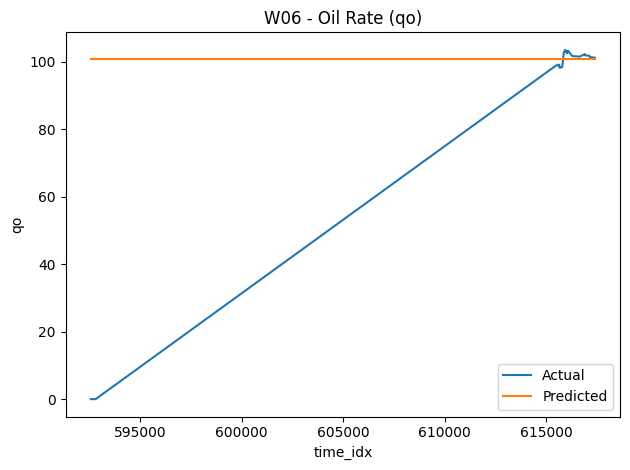

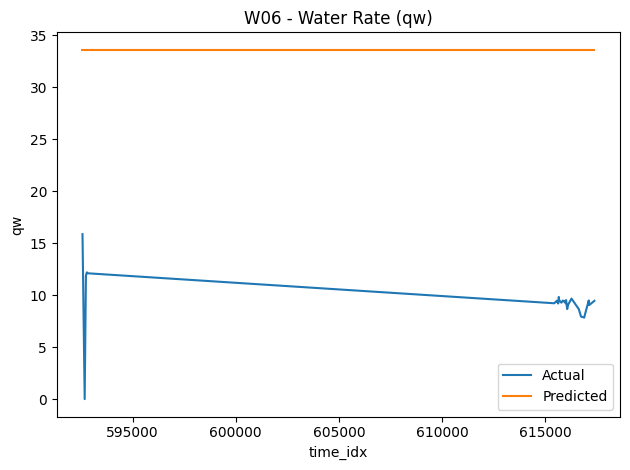

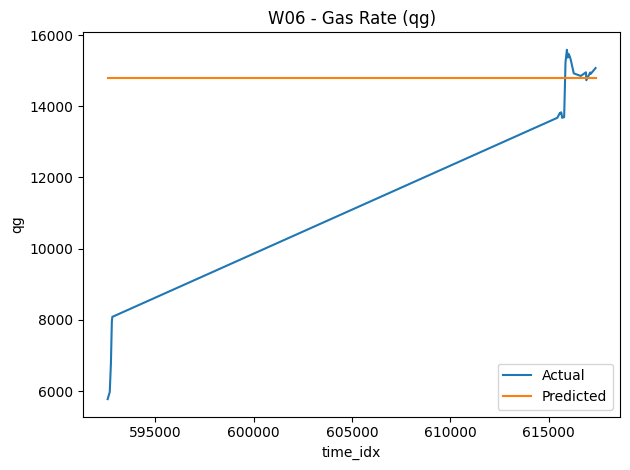

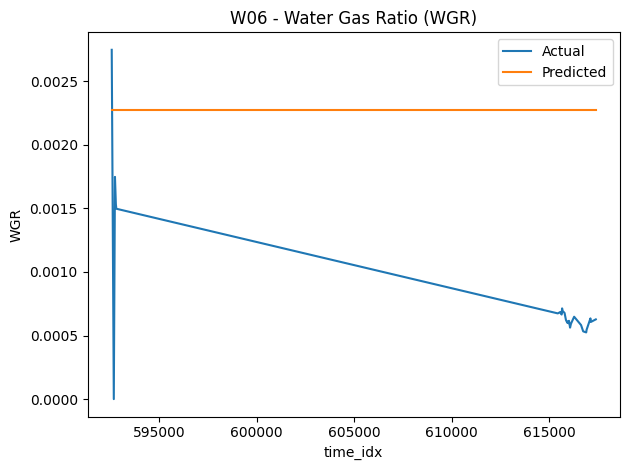

In [169]:
model.plot_predictions(df=df_test, time_col="time_idx")

In [170]:
def lowo_with_partial_calibration(
    df,
    n_calibration_points=2,
):
    results = []

    for test_well in df["well_id"].unique():
        df_well = df[df["well_id"] == test_well]
        df_train_other = df[df["well_id"] != test_well]

        df_cal = df_well.iloc[:n_calibration_points]
        df_test = df_well.iloc[n_calibration_points:]

        df_train = pd.concat([df_train_other, df_cal])

        model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars)
        # model.phys_model.fit_pres = False
        model.fit(df_train)

        results.append({
            "well": test_well,
            "scores": model.hybrid_score(df_test)
        })

    return results


In [171]:
# lowo_with_partial_calibration(df=df_with_targets)